# **Disturbance and Fault Detection of Induction Motor using Deep Learning**

## DATASET CREATION

In [1]:
# importing libraries
import pandas as pd
import numpy as np

In [2]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# importing data
path = '/content/drive/MyDrive/sem7_project/final/data.csv'
data = pd.read_csv(path)

In [4]:
data  = data.sample(frac = 1)
data = data.reset_index(drop=True)
print(data)

     temp   vib  speed   current  voltage  output
0   51.20  1.34     500     21.0      220       1
1   36.22  1.25     500     21.0      220       0
2   29.50  1.32    1423      4.5      230       0
3   25.40  1.34    1390      4.5      230       0
4   41.10  0.84     500     21.0      220       1
5   32.00  0.90    1380      4.5      230       1
6   45.30  1.08     500     21.0      220       1
7   31.00  1.05    1460      4.5      230       1
8   32.10  1.45    1442      4.5      230       0
9   40.10  1.34    1440      4.5      230       1
10  29.00  1.41    1430      4.5      230       0
11  43.00  1.37     500     21.0      220       1
12  29.10  1.45    1420      4.5      230       0
13  29.30  1.32    1430      4.5      230       0
14  29.90  1.27    1420      4.5      230       0
15  56.30  1.89     500     21.0      220       1
16  43.10  1.35     500     21.0      220       1
17  43.20  1.34     500     21.0      220       1
18  35.00  1.24     500     21.0      220       0


In [5]:
# Description of data
data.describe()

,temp,vib,speed,current,voltage,output
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,35.718776,1.261633,1047.530612,10.561224,226.326531,0.489796
std,7.956932,0.209974,467.507135,8.036786,4.870779,0.505076
min,25.400000,0.820000,0.000000,4.500000,220.000000,0.000000
25%,29.500000,1.120000,500.000000,4.500000,220.000000,0.000000
50%,32.300000,1.300000,1380.000000,4.500000,230.000000,0.000000
75%,41.100000,1.390000,1420.000000,21.000000,230.000000,1.000000
max,56.300000,1.890000,1474.000000,21.000000,230.000000,1.000000


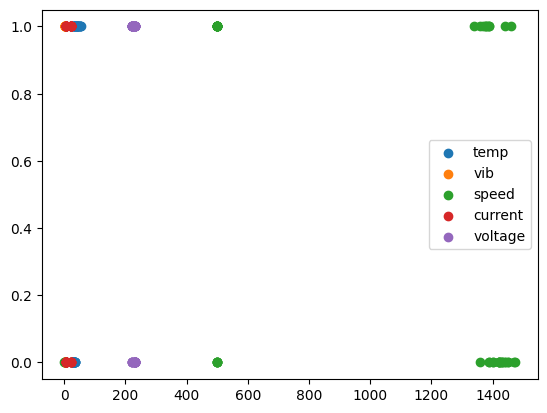

In [6]:
# single plot visualizatons
import matplotlib.pyplot as plt

x1=data['temp']
y=data['output']
x2=data['vib']
x3=data['speed ']
x4=data['current']
x5=data['voltage']

plt.scatter(x1,y)
plt.scatter(x2,y)
plt.scatter(x3,y)
plt.scatter(x4,y)
plt.scatter(x5,y)
li=['temp','vib','speed','current','voltage']
plt.legend(li)
plt.show()


## GENERATION OF SYNTHETIC DATA
&copy; Research Teams at Indian Institute of Science, Education and Research Tiruvananthapuram. All rights reserved. Any attempt to copy this work infringes with the rights.

In [7]:
# Initial inspections for
no_f=data['output'].value_counts()[0]/len(data)*100
f=data['output'].value_counts()[1]/len(data)*100
print("No error=",no_f,"\nError =",f)

No error= 51.02040816326531 
Error = 48.97959183673469


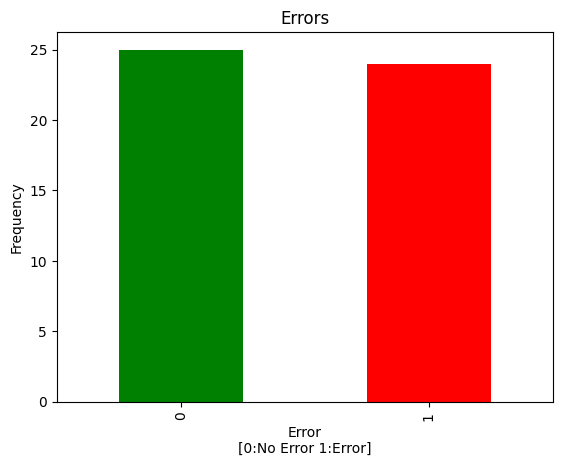

In [8]:
# Plotting frequency on bar graph
import matplotlib.pyplot as plt
%matplotlib inline

count_classes = pd.value_counts(data['output'], sort = True).sort_index()
count_classes.plot(kind = 'bar',color=['green','red'])
plt.title("Errors")
plt.xlabel("Error\n[0:No Error 1:Error]")
plt.ylabel("Frequency")
plt.show()

In [9]:
# seperating classes with two labels
data_1=data[data.output==1]
data_0=data[data.output==0]

### TVAE model creation

In [10]:
# importing needed libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler


In [11]:
# creating float Tensor for our dataset
class ErrorDataset(Dataset):
    def __init__(self, features):
        self.features = torch.FloatTensor(features)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index]


In [12]:
# defining the TVAE model architecture
class TVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(TVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)  # The last layer outputs mean and log variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Output is scaled between 0 and 1
        )
        self.dropout = nn.Dropout(p=0.7)  # Dropout layer

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        latent_stats = self.encoder(x)
        mu, logvar = torch.chunk(latent_stats, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar

In [13]:
# training function
def working(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for inputs in dataloader:
        inputs = inputs.to(device)
        optimizer.zero_grad()
        reconstructed, mu, logvar = model(inputs)
        loss = criterion(reconstructed, inputs, mu, logvar)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

In [14]:
 # loss function
def tvae_loss(reconstructed, inputs, mu, logvar):
    reconstruction_loss = nn.BCELoss(reduction='sum')(reconstructed, inputs)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence


In [15]:
# manuel seeding
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [16]:
# function to call the model and train it
def train_model(df):
  # spliting the dataset into features and labels
  features = df.drop("output", axis=1).values
  labels = df["output"].values

    # performing feature scaling on the features
  scaler = StandardScaler()
  features = scaler.fit_transform(features)
    # creating the dataset

  dataset = ErrorDataset(features)

  # creating a data loader for the dataset
  batch_size = 16
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  # initializing the TVAE model
  input_dim = features.shape[1]
  hidden_dim = 32
  latent_dim = 5
  tvae_model = TVAE(input_dim, hidden_dim, latent_dim).to(device)


  lr = 0.001
  num_epochs = 100
  weight_decay = 1e-5


  optimizer = optim.Adam(tvae_model.parameters(), lr=lr,weight_decay=weight_decay)
  criterion = tvae_loss



In [17]:
# function for synthetic data generator
def generator(input_dim,no):
  num_samples = no
  latent_dim = 5
  tvae_model = TVAE(input_dim, 256, latent_dim).to(device)
  latent_samples = torch.randn(num_samples, latent_dim).to(device)
  synthetic_data = tvae_model.decoder(latent_samples).detach().cpu()
  return synthetic_data


### Class 0 Data Generation

In [18]:
# fet and labels
features = data_0.drop('output', axis=1).values
labels = data_0['output'].values

In [19]:
# training and generation
train_model(data_0);

In [20]:
# generation of samples
no = 1000
samples=generator(features.shape[1],no)

 # balancing
arr=samples.numpy()
samples=pd.DataFrame(arr)
samples['output']=[0]*no
samples.columns=['temp', 	'vib', 	'speed ', 	'current', 	'voltage', 	'output']
new_data_0=pd.concat([data_0,samples])
new_data_0=new_data_0.sample(frac=1)

In [21]:
# denormalization
new_data_0['temp'] = new_data_0['temp']*50
new_data_0['vib'] = new_data_0['vib']*2
new_data_0['speed '] = new_data_0['speed ']*2000
new_data_0['current'] = new_data_0['current']*10
new_data_0['voltage'] = new_data_0['voltage']*500


In [22]:
print(new_data_0.to_markdown())

|     |      temp |      vib |       speed  |   current |    voltage |   output |
|----:|----------:|---------:|-------------:|----------:|-----------:|---------:|
| 502 |   27.3251 | 1.1722   |  944.452     |   4.28094 |    257.837 |        0 |
| 334 |   31.5304 | 1.17916  | 1001.15      |   5.30396 |    226.947 |        0 |
| 422 |   27.55   | 0.985528 | 1130.29      |   5.97278 |    196.031 |        0 |
|   6 |   27.9578 | 0.889134 | 1050.27      |   5.76802 |    252.329 |        0 |
| 596 |   28.0679 | 1.18671  |  989.075     |   4.01684 |    257.438 |        0 |
| 565 |   25.5916 | 1.09963  | 1052.6       |   5.54312 |    215.545 |        0 |
| 880 |   32.6008 | 1.04822  |  906.684     |   5.30837 |    287.869 |        0 |
| 712 |   26.3236 | 1.03153  |  830.838     |   4.77316 |    295.626 |        0 |
|  51 |   29.3506 | 1.11806  | 1006.31      |   5.10496 |    220.671 |        0 |
| 923 |   24.8682 | 1.08529  |  879.854     |   4.57194 |    239.114 |        0 |
| 407 |   29.481

### Class 1 Data Generation

In [23]:
# fet and labels
features = data_1.drop('output', axis=1).values
labels = data_1['output'].values

In [24]:
# training and generation
train_model(data_1)

In [25]:
# generation of samples
no = 1000
samples=generator(features.shape[1],no)

 # balancing

arr=samples.numpy()
samples=pd.DataFrame(arr)
samples['output']=[1]*no
samples.columns=['temp', 	'vib', 	'speed ', 	'current', 	'voltage', 	'output']
new_data_1=pd.concat([data_0,samples])
new_data_1=new_data_1.sample(frac=1)

In [26]:
# denormalization
new_data_1['temp'] = new_data_1['temp']*50
new_data_1['vib'] = new_data_1['vib']*2
new_data_1['speed '] = new_data_1['speed ']*2000
new_data_1['current'] = new_data_1['current']*10
new_data_1['voltage'] = new_data_1['voltage']*500


In [27]:
print(new_data_1.to_markdown())

|     |      temp |      vib |       speed  |   current |    voltage |   output |
|----:|----------:|---------:|-------------:|----------:|-----------:|---------:|
| 112 |   26.0415 | 0.895976 |  989.071     |   4.62117 |    239.272 |        1 |
|  44 |   26.4497 | 1.01474  |  841.268     |   3.67544 |    220.729 |        1 |
| 324 |   28.9325 | 0.820464 | 1031.28      |   4.50906 |    275.512 |        1 |
| 462 |   25.6161 | 0.859142 |  967.29      |   5.74333 |    230.453 |        1 |
| 305 |   26.1008 | 0.982135 |  938.537     |   4.68593 |    216.145 |        1 |
| 752 |   28.2019 | 0.836763 | 1085.09      |   5.26265 |    225.643 |        1 |
| 951 |   26.1179 | 0.737175 | 1076.67      |   5.20833 |    241.638 |        1 |
| 382 |   29.8382 | 0.932391 | 1122.19      |   5.78064 |    253.132 |        1 |
| 411 |   23.9077 | 0.980257 |  960.513     |   4.62586 |    255.95  |        1 |
| 903 |   24.5373 | 0.870196 | 1059.45      |   4.47856 |    260.549 |        1 |
| 902 |   26.524

### Combining the classes and visuals

In [28]:
data_final = pd.concat([new_data_0,new_data_1])
data_final=data_final.sample(frac=1)

In [29]:
print(data_final.to_markdown())

|     |      temp |      vib |       speed  |   current |    voltage |   output |
|----:|----------:|---------:|-------------:|----------:|-----------:|---------:|
| 549 |   25.3346 | 0.808298 | 1062.76      |   4.84137 |    246.051 |        1 |
| 777 |   32.035  | 1.14542  | 1059.08      |   5.9298  |    201.782 |        0 |
| 236 |   26.3415 | 0.90633  | 1028.2       |   4.47882 |    258.542 |        1 |
| 545 |   24.8853 | 0.80974  |  952.467     |   5.69041 |    212.421 |        1 |
| 127 |   30.2088 | 1.17532  |  965.799     |   5.30773 |    245.993 |        0 |
| 917 |   24.6766 | 1.01437  |  860.683     |   5.23973 |    249.649 |        1 |
|   3 | 1270      | 2.68     |    2.78e+06  |  45       | 115000     |        0 |
| 418 |   23.9994 | 0.961057 |  954.493     |   4.93076 |    248.252 |        1 |
|  82 |   18.5324 | 0.820412 | 1023.19      |   4.71171 |    274.684 |        1 |
|  87 |   27.6455 | 0.670003 | 1212.26      |   4.56453 |    236.707 |        1 |
| 479 |   26.175

In [30]:
data_final.describe()

,temp,vib,speed,current,voltage,output
count,2050.000000,2050.000000,2.050000e+03,2050.000000,2050.000000,2050.000000
mean,62.808622,1.003816,5.863263e+04,6.783886,3016.107749,0.487805
std,230.435233,0.286830,3.898161e+05,15.281643,17555.177770,0.499973
min,15.975045,0.587140,0.000000e+00,3.055354,113.839388,0.000000
25%,24.941338,0.886885,9.159444e+02,4.567550,227.350049,0.000000
50%,26.862134,0.965356,9.951113e+02,4.988899,244.704574,0.000000
75%,28.594140,1.040309,1.062080e+03,5.427826,260.036014,1.000000
max,1811.000000,3.080000,2.948000e+06,210.000000,115000.000000,1.000000


In [31]:
data.describe()

,temp,vib,speed,current,voltage,output
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,35.718776,1.261633,1047.530612,10.561224,226.326531,0.489796
std,7.956932,0.209974,467.507135,8.036786,4.870779,0.505076
min,25.400000,0.820000,0.000000,4.500000,220.000000,0.000000
25%,29.500000,1.120000,500.000000,4.500000,220.000000,0.000000
50%,32.300000,1.300000,1380.000000,4.500000,230.000000,0.000000
75%,41.100000,1.390000,1420.000000,21.000000,230.000000,1.000000
max,56.300000,1.890000,1474.000000,21.000000,230.000000,1.000000


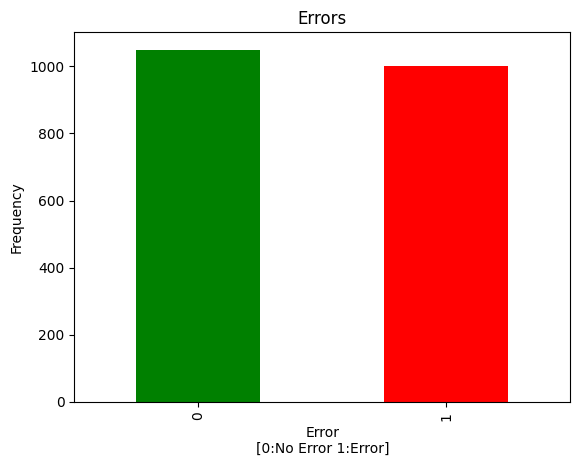

In [32]:
# Plotting frequency on bar graph
import matplotlib.pyplot as plt
%matplotlib inline

count_classes = pd.value_counts(data_final['output'], sort = True).sort_index()
count_classes.plot(kind = 'bar',color=['green','red'])
plt.title("Errors")
plt.xlabel("Error\n[0:No Error 1:Error]")
plt.ylabel("Frequency")
plt.show()

### Visualizing the efficiency


In [33]:
# Splitting into train and test in 4:1
from sklearn.model_selection import train_test_split
train, test=train_test_split(data_final,test_size=0.20,random_state=1)

In [34]:
# split train data into features and labels
x = train.drop('output', axis=1).values.astype(float)
y = train['output'].values.astype(float)

In [35]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [36]:
# Creating 10-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [37]:
# Calling the classifier with 10 branches
rf_classifier = RandomForestClassifier(n_estimators=10, random_state=42)

In [38]:
# Performing cross-validation
scores = cross_val_score(rf_classifier, x, y, cv=kfold)

In [39]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, cohen_kappa_score, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, matthews_corrcoef, balanced_accuracy_score, make_scorer

In [40]:
# Define the evaluation metrics
scoring = {
    'F1-Score': make_scorer(f1_score, average='macro'),

}

In [41]:
# Perform cross-validation and calculate evaluation metrics
scores = cross_validate(rf_classifier, x, y, cv=kfold, scoring=scoring)

In [42]:
# Print the evaluation metrics for each fold and the mean values
for metric in scores.keys():
    fold_scores = scores[metric]
    print(metric,':', fold_scores,'\n')
    print("Mean",metric,':', fold_scores.mean(),"\n")

fit_time : [0.03328848 0.04130578 0.03390551 0.03151727 0.03626251 0.03021312
 0.02969861 0.02939773 0.02942777 0.03451753] 

Mean fit_time : 0.032953429222106936 

score_time : [0.00236726 0.00349593 0.00240326 0.0025754  0.00248361 0.00225329
 0.00265121 0.00257516 0.0027287  0.00249267] 

Mean score_time : 0.0026026487350463865 

test_F1-Score : [0.91417464 0.88531469 0.93556499 0.89587302 0.91276596 0.9265562
 0.92072876 0.8900968  0.88965311 0.89633761] 

Mean test_F1-Score : 0.9067065764745452 



## MODEL 1 - BINARY CLASSIFIER

In [43]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split


In [44]:
# Splitting the data into training and testing sets
train,test = train_test_split(data_final, test_size=0.2, random_state=42)

In [46]:
# Building the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(5,)),  # Input layer
    tf.keras.layers.Dense(128, activation='relu'),  # Hidden layer with 128 units and ReLU activation
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer with 1 unit and sigmoid activation
])

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               768       
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 897 (3.50 KB)
Trainable params: 897 (3.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
# Eval metrics
# Custom callback to collect training speed and convergence per epoch
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
import time
class TrainingStatsCallback(Callback):
    def __init__(self):
        self.start_time = 0
        self.steps = 0
        self.speeds = []
        self.convergences = []

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_train_batch_end(self, batch, logs=None):
        self.steps += 1

    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            epoch_time = time.time() - self.start_time
            speed = epoch_time / self.steps
            self.speeds.append(speed)
            self.convergences.append(logs.get('loss'))
            self.steps = 0

In [50]:
x_train = train.drop('output', axis=1)
y_train = train['output']
x_test = test.drop('output', axis=1)
y_test = test['output']

In [51]:

# Define the model checkpoint
checkpoint = ModelCheckpoint('model.h5', monitor='loss', verbose=0, save_best_only=True, mode='min')

# Define the training stats callback
stats_callback = TrainingStatsCallback()

# Training the model
model.fit(x_train, y_train, epochs=1000, batch_size=32, validation_split=0.1, callbacks=[checkpoint, stats_callback])

Epoch 1/1000
47/47 [==============================] - 2s 8ms/step - loss: 55.3063 - accuracy: 0.4966 - val_loss: 17.7373 - val_accuracy: 0.5061
Epoch 2/1000
47/47 [==============================] - ETA: 0s - loss: 4.8233 - accuracy: 0.5142

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 0s 5ms/step - loss: 4.8233 - accuracy: 0.5142 - val_loss: 1.4709 - val_accuracy: 0.5488
Epoch 3/1000
47/47 [==============================] - 0s 5ms/step - loss: 1.1385 - accuracy: 0.5014 - val_loss: 1.0334 - val_accuracy: 0.4512
Epoch 4/1000
47/47 [==============================] - 0s 4ms/step - loss: 0.9956 - accuracy: 0.4763 - val_loss: 1.1026 - val_accuracy: 0.5183
Epoch 5/1000
47/47 [==============================] - 0s 5ms/step - loss: 0.9523 - accuracy: 0.4573 - val_loss: 0.9073 - val_accuracy: 0.4390
Epoch 6/1000
47/47 [==============================] - 0s 4ms/step - loss: 0.8818 - accuracy: 0.4973 - val_loss: 0.8613 - val_accuracy: 0.4817
Epoch 7/1000
47/47 [==============================] - 0s 5ms/step - loss: 0.8423 - accuracy: 0.5047 - val_loss: 0.8098 - val_accuracy: 0.4939
Epoch 8/1000
47/47 [==============================] - 0s 5ms/step - loss: 0.8018 - accuracy: 0.5271 - val_loss: 0.7787 - val_accuracy: 0.4451
Epoch 9/1000
47/47 

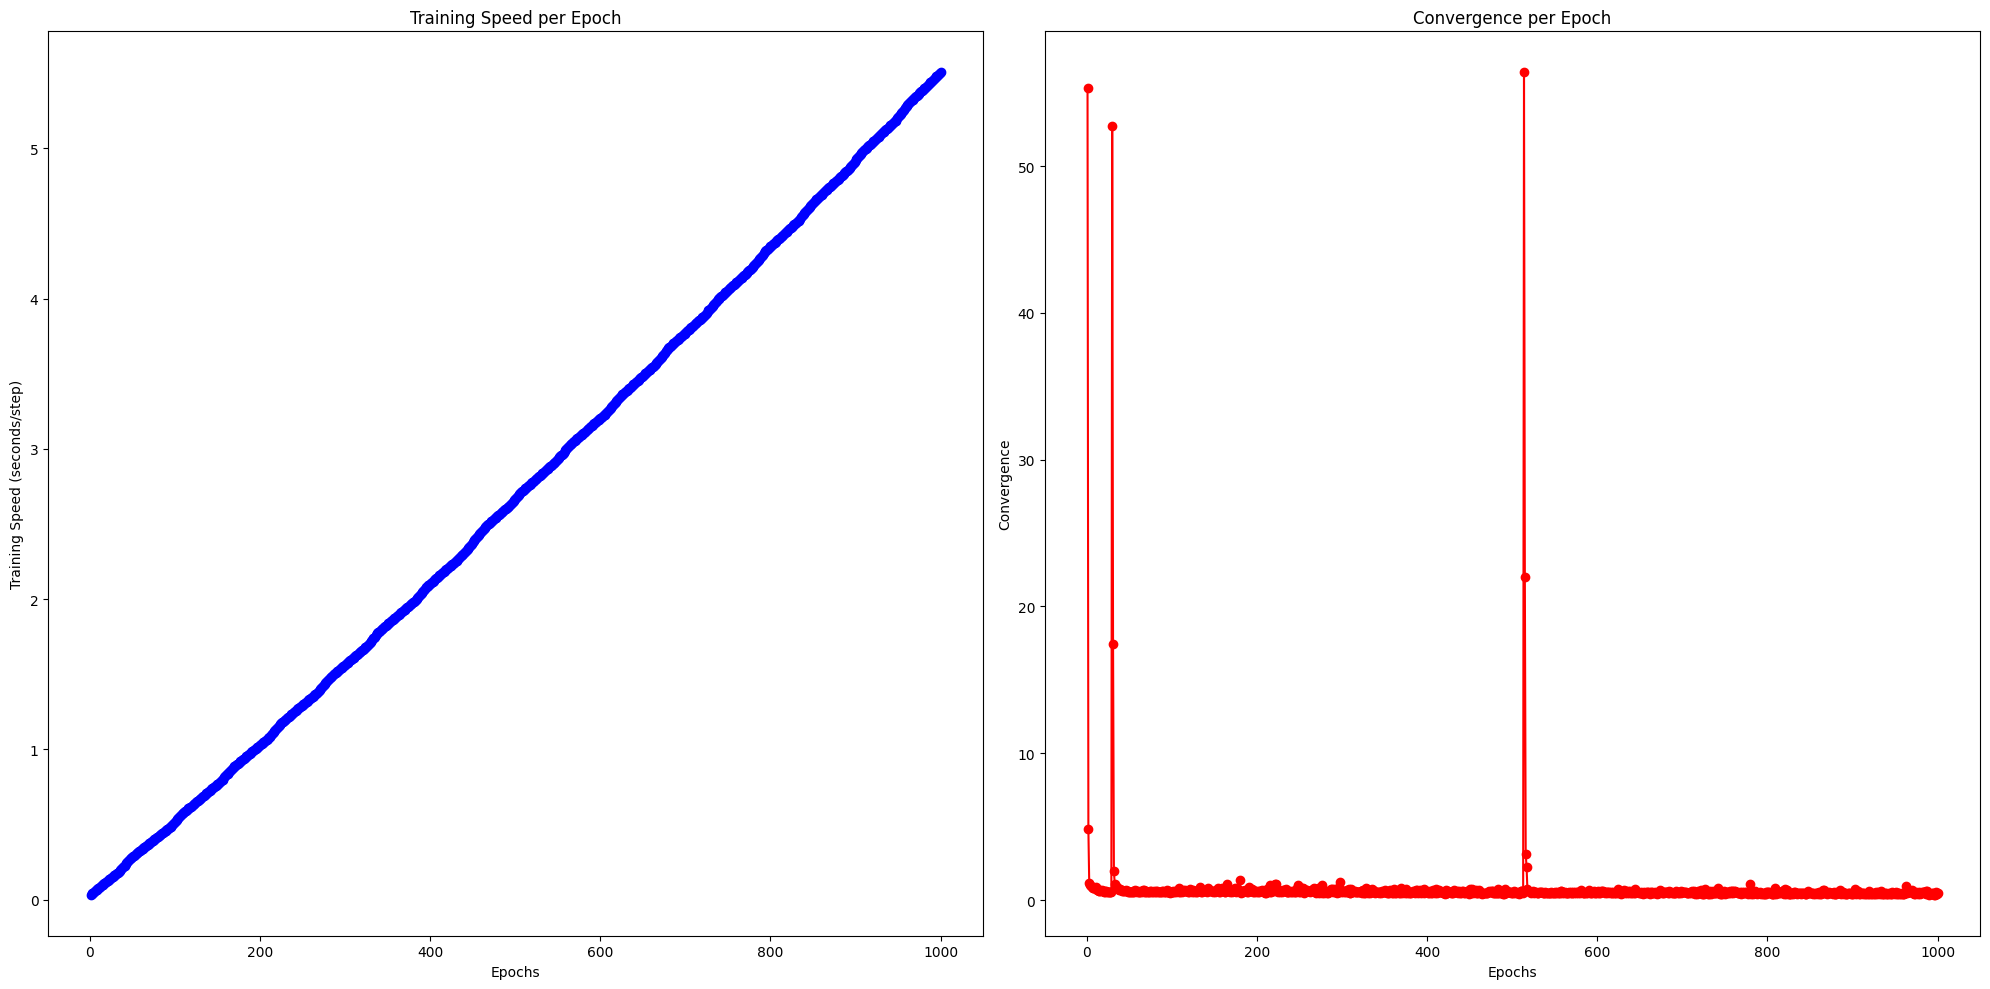

In [52]:
# Training efficiency
# Plot the training speed and convergence per epoch
epochs = range(1, len(stats_callback.speeds) + 1)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs, stats_callback.speeds, 'b-o')
plt.xlabel('Epochs')
plt.ylabel('Training Speed (seconds/step)')
plt.title('Training Speed per Epoch')

plt.subplot(1, 2, 2)
plt.plot(epochs, stats_callback.convergences, 'r-o')
plt.xlabel('Epochs')
plt.ylabel('Convergence')
plt.title('Convergence per Epoch')

plt.tight_layout()
plt.show()

In [54]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

13/13 [==============================] - 0s 3ms/step - loss: 0.3961 - accuracy: 0.7927
Test loss: 0.3961
Test accuracy: 0.7927


In [56]:
# prediction
new_features = 5
inp  = list()
name = ['temp','vib','speed','current','voltage']
for i in range(5):
  print("Enter",name[i])
  g = input()
  inp.append(float(g))
#x_new = np.random.randn(1, 5)  # Replace this with your actual new input
prediction = model.predict(np.array(inp).reshape((1,5)))
predicted_class = (prediction > 0.5).astype(int)

print("Predicted Probability:", prediction[0][0])
print("Predicted Class:", predicted_class[0][0])

Enter temp
23
Enter vib
1.2
Enter speed
1300
Enter current
4.2
Enter voltage
400
1/1 [==============================] - 0s 27ms/step
Predicted Probability: 0.9991115
Predicted Class: 1
